In [1]:
import sys
sys.path.append("../code/")
from wiki_dataset import get_wiki_dataset
from __future__ import division
from __future__ import print_function
import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L
import os
from chainer import training
from chainer.training import extensions
from chainer.functions import softmax 

# Idea
In this notebook I will train the language models that I can use in a later stadium to try to learn the linear mapping from model a to model b. In this model we get as input a word embedding and as output the next word in the sequence. 

I will train a model for spanish and english.

## Model
Our model is based on the https://github.com/pfnet/chainer/tree/master/examples/ptb model.  

In [2]:
# This a simple language model, directly copied from the tutorial
class RNNLM(chainer.Chain):

    def __init__(self, n_vocab, n_units, train=True):
        super(RNNLM, self).__init__(
            embed=L.EmbedID(n_vocab, n_units),
            l1=L.LSTM(n_units, n_units),
            l2=L.LSTM(n_units, n_units),
            l3=L.Linear(n_units, n_vocab),
        )
        self.n_units = n_units
        self.n_vocab = n_vocab
        # Initialize with uniform distribution, expect for our linear tranformation layer
        #for param in self.params():
        #    param.data[...] = np.random.uniform(-0.1, 0.1, param.data.shape)
        
        self.train = train

    def reset_state(self):
        self.l1.reset_state()
        self.l2.reset_state()

    def __call__(self, x):
        h0 = self.embed(x)
        h2 = self.l1(F.dropout(h0, train=self.train))
        h3 = self.l2(F.dropout(h2, train=self.train))
        y = self.l3(F.dropout(h3, train=self.train))
        return y

## Dataset iterator

From the tutorial we re-use the following code:
- **ParallelSequentialIteratior**: This class takes a dataset and creates batches(with batch size N) from it. In the first \_\_next()\_\_ step it will give the first words of N sequences as input and as target value the next word in the sequence. In the next \_\_next\_\_() call it will return the 2nd word of N sequences as input and the third word for as target etc. Running multiple sequences at the same time allows for efficient matrix multiplication(especially useful for GPU acceleration) furthermore the gradients for all sequences can be summed and applied immediately(allowing for statistic gradient descent). 
- **BPTTUpdater**: To obtain the weight gradients for our neural network we make use of back propagation trough time algorithm. It unfolds a neural network into a normal feedforward network where each layer represents one timestep, and then sums the gradients for each connection. The gradients are only saved for a fixed number of steps ("truncated"). 
- **Compute perplexity**: Perplexity is a measurement often used to evaluate language models in NLP context. It  assumes to obtain the softmax classification error as is used by default by the [chainer L.Classifier link](http://docs.chainer.org/en/stable/_modules/chainer/links/model/classifier.html?highlight=Classifier)

In [3]:
# Dataset iterator to create a batch of sequences at different positions.
# This iterator returns a pair of current words and the next words. Each
# example is a part of sequences starting from the different offsets
# equally spaced within the whole sequence.
class ParallelSequentialIterator(chainer.dataset.Iterator):

    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = batch_size  # batch size
        # Number of completed sweeps over the dataset. In this case, it is
        # incremented if every word is visited at least once after the last
        # increment.
        self.epoch = 0
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        self.repeat = repeat
        length = len(dataset)
        # Offsets maintain the position of each sequence in the mini-batch.
        self.offsets = [i * length // batch_size for i in range(batch_size)]
        # NOTE: this is not a count of parameter updates. It is just a count of
        # calls of ``__next__``.
        self.iteration = 0

    def __next__(self):
        # This iterator returns a list representing a mini-batch. Each item
        # indicates a different position in the original sequence. Each item is
        # represented by a pair of two word IDs. The first word is at the
        # "current" position, while the second word at the next position.
        # At each iteration, the iteration count is incremented, which pushes
        # forward the "current" position.
        length = len(self.dataset)
        if not self.repeat and self.iteration * self.batch_size >= length:
            # If not self.repeat, this iterator stops at the end of the first
            # epoch (i.e., when all words are visited once).
            raise StopIteration
        cur_words = self.get_words()
        self.iteration += 1
        next_words = self.get_words()

        epoch = self.iteration * self.batch_size // length
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch

        return list(zip(cur_words, next_words))

    @property
    def epoch_detail(self):
        # Floating point version of epoch.
        return self.iteration * self.batch_size / len(self.dataset)

    def get_words(self):
        # It returns a list of current words.
        return [self.dataset[(offset + self.iteration) % len(self.dataset)]
                for offset in self.offsets]

    def serialize(self, serializer):
        # It is important to serialize the state to be recovered on resume.
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)


# Custom updater for truncated BackProp Through Time (BPTT)
class BPTTUpdater(training.StandardUpdater):

    def __init__(self, train_iter, optimizer, bprop_len, device):
        super(BPTTUpdater, self).__init__(
            train_iter, optimizer, device=device)
        self.bprop_len = bprop_len

    # The core part of the update routine can be customized by overriding.
    def update_core(self):
        loss = 0
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')

        # Progress the dataset iterator for bprop_len words at each iteration.
        for i in range(self.bprop_len):
            # Get the next batch (a list of tuples of two word IDs)
            batch = train_iter.__next__()

            # Concatenate the word IDs to matrices and send them to the device
            # self.converter does this job
            # (it is chainer.dataset.concat_examples by default)
            x, t = self.converter(batch, self.device)

            # Compute the loss at this time step and accumulate it
            loss += optimizer.target(chainer.Variable(x), chainer.Variable(t))

        optimizer.target.cleargrads()  # Clear the parameter gradients
        loss.backward()  # Backprop
        loss.unchain_backward()  # Truncate the graph
        optimizer.update()  # Update the parameters


# Routine to rewrite the result dictionary of LogReport to add perplexity
# values
def compute_perplexity(result):
    result['perplexity'] = np.exp(result['main/loss'])
    if 'validation/main/loss' in result:
        result['val_perplexity'] = np.exp(result['validation/main/loss'])

## Dataset:
First we have to divide our training, test and validation set. I use rougly the same fractions that are used in the get_ptb_words() dataset. First a 10% - 90% training - validation split. Then split the training again 10% - 90% to obtain a test and training set.

In [4]:
def retrieve_and_split(dump):
    seq, voc = get_wiki_dataset(dump)
    seq = seq.astype(np.int32)
    
    val_start = int(len(seq) * .9)
    test_start = int(val_start *.9)
    train = seq[:test_start]
    test = seq[test_start:val_start]
    val = seq[val_start:]
    
    return train, val, test, voc

## Model training

In [5]:
def train(dump, name, test_mode=False, epoch=5, batch_size=128, gpu=-1, out='result', grad_clip=True, brpoplen=35, resume='',max_seq_size=250000):
    """

    """
    train, val, test, voc = retrieve_and_split(dump,max_seq_size)
    n_vocab = len(voc)
    # n_vocab=10
    print("Going to run %s" % name)
    print("#training: %d, #val: %d, #test: %d" % (len(train), len(val), len(test)))
    print("#vocabulary: %d" % n_vocab)

    if test_mode:
        print("Running in test mode: cutting test, train and val set to 100 elements each")
        train = train[:10000]
        test = test[:100]
        val = val[:100]
        if batch_size > 100:
            batch_size = 100

    train_iter = ParallelSequentialIterator(train, batch_size)
    val_iter = ParallelSequentialIterator(val, 1, repeat=False)
    test_iter = ParallelSequentialIterator(test, 1, repeat=False)

    # Prepare an RNNLM model
    print("Creating model")
    rnn = RNNLM(n_vocab, 800)
    print("Init model complete")
    model = L.Classifier(rnn)
    model.compute_accuracy = False  # we only want the perplexity
    if gpu >= 0:
        chainer.cuda.get_device(gpu).use()  # make the GPU current
        model.to_gpu()

    # Set up an optimizer
    optimizer = chainer.optimizers.SGD(lr=1.0)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))

    # Set up a trainer
    updater = BPTTUpdater(train_iter, optimizer, brpoplen, gpu)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

    eval_model = model.copy()  # Model with shared params and distinct states
    eval_rnn = eval_model.predictor
    eval_rnn.train = False
    trainer.extend(extensions.Evaluator(
        val_iter, eval_model, device=gpu,
        # Reset the RNN state at the beginning of each evaluation
        eval_hook=lambda _: eval_rnn.reset_state()))

    interval = 10 if test_mode else 500

    trainer.extend(extensions.ExponentialShift('lr', 0.5),
                   trigger=(25, 'epoch'))
    trainer.extend(extensions.LogReport(postprocess=compute_perplexity,
                                        trigger=(interval, 'iteration')))
    trainer.extend(extensions.PrintReport(
        ['epoch', 'iteration', 'perplexity', 'val_perplexity']
    ), trigger=(interval, 'iteration'))
    trainer.extend(extensions.ProgressBar(
        update_interval=10 if test_mode else 125))
    
    #this extension makes sure our parameters are saved to the disk so we can use it later
    trainer.extend(extensions.snapshot())
    trainer.extend(extensions.snapshot_object(
        model, 'model_iter_{.updater.iteration}'))
    if resume:
        chainer.serializers.load_npz(resume, trainer)
    date = time.strftime("%Y-%m-%d_%H-%M-%S")
    fn_a = 'loss_%s.png' % date
    loss_r = extensions.PlotReport(['validation/main/loss','main/loss'],'epoch',file_name=fn_a)

    trainer.extend(loss_r)
    start = time.time()
    trainer.run()

    diff = time.time() - start
    
    # Evaluate the final model
    print('test')
    eval_rnn.reset_state()
    evaluator = extensions.Evaluator(test_iter, eval_model, device=gpu)
    result = evaluator()
    print('test perplexity:', np.exp(float(result['main/loss'])))
    com.add_text("final loss",result['main/loss'])



I actually executed this script via a batch script for english and spanish on a GPU machine. Using the `sh scripts/english_lm.sh` and `sh scripts/spanish_lm.sh`. These bash scripts use the `code/lm.py` script to perform the training. Which will import shared code from helpers.py and models.py. I copy the generated plots, latest snapshot and exact dataset(using `sh scripts/dump_(english|spanish).sh` to my local machine.

## Analyse learned language models
We will now see if the learned language models are well trained language models by letting the network generate some text and by mapping the embedding to a 2d space and see if we can find any linear similarities.

In [6]:
from models import load_rnn_model
import re
from chainer.functions.activation.softmax import softmax
def tokenize(line):
    line = line.replace("<br>", " ").replace(". ", " <eos> ").lower()
    for token in re.findall("[\w\<\>]+", line, re.UNICODE):
        yield token
def read_dataset(file):
    """
    Reads dataset that was exported by export_dataset
    :param file:
    :return:
    """
    np.load(file)
    data = np.load(file)
    seq,voc = data['seq'],data['voc']
    seq = seq.astype(np.int32)
    return seq,voc

#### Load datasets and models
This loads the datasets and parameter matrixes for the network into memory. These files are obtained by manually running `sh scripts/spanish_lm.sh` and `sh scripts/spanish_en.sh`

In [7]:
#refer to data obtained from our machine
ENGLISH_FOLDER = os.path.join(os.getcwd(),"../result-english/")
SPANISH_FOLDER = os.path.join(os.getcwd(),"../result-spanish/")
model_english = os.path.join(ENGLISH_FOLDER,'650_u_45_e_1M_v_5_th_model')
model_spanish = os.path.join(SPANISH_FOLDER,'650_u_45_e_1M_v_5_th_model')
seq_en, voc_en = read_dataset(os.path.join(ENGLISH_FOLDER,'data.npz'))
seq_es, voc_es = read_dataset(os.path.join(SPANISH_FOLDER,'data.npz'))
rnn_en = load_rnn_model(model_english,len(voc_en),650)
rnn_es = load_rnn_model(model_spanish,len(voc_es),650)
print("The english vocabulary contains %d different words" % len(voc_en))
print("The spanish vocabulary contains %d different words" % len(voc_es))

The english vocabulary contains 15736 different words
The spanish vocabulary contains 16509 different words


#### Generating text
We will now generate some text from both the models. We first feed our network with a seed. After this we predict the next word of the network, we normalize the top-5 highest probablities and scale these 5 probablities linearly to a valid probablity distribution, randomly pick one, and seed that one. We repeat this process untill we reach a text of 100 words. We always ignore the <below_th> catch-all word. We found that if we didn't sample the words, but just pick the highest probability, the network would be stuck in a more repitative pattern. 

In [10]:
from operator import itemgetter
from heapq import nlargest
TOP_N = 5 # Number of 

# Shared helping functions
def create_inverse_voc(voc):
    """ Creates inverse vocabulary from word to index
    """
    return dict([(word,idx) for idx,word in enumerate(voc)])


def map_line_to_seq(line,inverse_voc):
    """ Converts a string(sentence) to a sequence of integers
    Will also tokenize the sentence
    """
    idxs = [inverse_voc[w] if w in inverse_voc else inverse_voc['<below_th>'] for w in tokenize(line)]
    print(idxs)
    return idxs


def fill_till_max(x,filler=-1,n=100):
    """ Will make an array of fixed size n, will use x to fill this array. 
    If len(x) < n will fill the rest with filler. 
    """
    return [x[i] if len(x) > i else filler for i in range(n)]


def map_seq_to_sentence(seq, voc):
    """ Maps seqs back to a readable sentence
    """
    return " ".join([voc[int(w)] for w in seq]).replace(" <eos>",".")
    

class TextGenerator():
    """ Generates text from language model
    
    """
    TOP_N = 5

    def __init__(self, lm, voc):
        self.lm = lm
        self.voc = voc
        self.inv_voc = create_inverse_voc(voc)
        

    def generate_text(self, seeds, max_len=100):
        self.lm.reset_state()
        # matrix of sentences in rows, words in columns
        text_idx = np.array([fill_till_max(map_line_to_seq(s, self.inv_voc), n=max_len) for s in seeds], dtype=np.int32)

        # i is the to predict word column
        for i in range(2, max_len):
            # Our input is all words before the one to predict
            before = i - 1

            # calculate probabilty
            x = self.lm(text_idx[:, before])
            d = softmax(x).data
            next_words = []
            d = np.delete(d, 0, 1)
            for r in range(d.shape[0]):
                top = nlargest(TextGenerator.TOP_N, enumerate(d[r, :]), itemgetter(1))
                idx = [x[0] for x in top]
                probs = [x[1] for x in top]
                probs = np.array(probs) / np.sum(probs)
                next_words.append(np.random.choice(idx, p=probs) + 1)

            for si, w in enumerate(next_words):
                if text_idx[si, i] < 0:
                    text_idx[si, i] = w

        return [map_seq_to_sentence(s, self.voc) for s in text_idx]


print("Generating for english:")
seeds = ["Sheep eat a lot of grass and produce wool. ", "The Golden Rule or law of reciprocity is the principle of treating others as one would wish"]
rnn_en.predictor.train = False
gen = TextGenerator(rnn_en.predictor, voc_en)
text = gen.generate_text(seeds)
for t in text:
    print(t)
print("----\n")
print("Generating for spanish:")
seeds = ["La oveja (Ovis orientalis aries)1 es un mamífero cuadrúpedo ungulado doméstico, usado como ganado. Como todos los rumiantes, las ovejas son artiodáctilos, o animales con pezuñas .", "Regla de oro o ley de oro1 son denominaciones para un principio moral general que puede expresarse: trata a los demás como querrías que te trataran a ti (en su forma positiva)"]
rnn_es.predictor.train = False
gen = TextGenerator(rnn_es.predictor, voc_es)
text = gen.generate_text(seeds)
for t in text:
    print(t)
    print("\n")


Generating for english:
[9086, 10514, 45, 327, 14, 7089, 30, 4243, 11517, 19]
[5, 528, 6228, 26, 3528, 14, 0, 91, 5, 3607, 14, 9400, 455, 24, 221, 275, 4845]
sheep eat a lot of grass and produce wool. the work is a part of the national institute of the arts of the city of the united states district <ref>< ref> in 2011 the following year he was elected to the national government of representatives for the national party of representatives and the national council of the national council for the national council of the national party of suriname and the national council of the united kingdom. it was also promoted to the local national council of suriname for the united states in 1984 and served on the
the golden rule or law of <below_th> is the principle of treating others as one would wish in any place in the united states in the country. the first time the combaticons was a member of the national society and the government of the national council for the public. the school was the firs

### Analysing the word embeddings
Similary to the work of mikolav, we want to see if it would be theoritacally possible to learn an linear embedding between the two languages. For this purpose we select the 10 most frequent words occuring in both languages, map the two languages to a 2d space using pca and plot them. For this purpose we make use of a modified version of: https://gist.github.com/chezou/3899461aa550f73854a1


In [9]:
from collections import Counter
c = Counter([s for s in seq_en if s != 0])
for w,n in c.most_common(100):
    print(voc_en[w],n)

the 61678
of 30433
<eos> 28886
in 27068
and 25189
a 20273
to 17515
was 11406
is 10654
ref> 10460
on 7783
for 7614
by 6750
as 6687
he 6439
s 6427
with 6201
at 5248
that 5016
his 5005
from 4758
it 4568
<ref>< 4216
an 3726
name 3711
<ref 2731
are 2596
were 2447
also 2381
which 2345
< 2275
has 2258
this 2241
first 2095
2011 2033
be 2032
she 1896
who 1892
one 1858
had 1779
her 1779
their 1679
after 1663
or 1662
not 1624
new 1584
but 1575
they 1561
two 1498
its 1469
>< 1434
series 1429
have 1363
1 1347
been 1279
all 1220
may 1139
2 1137
time 1115
during 1099
when 1090
other 1090
film 1013
there 1007
year 1000
world 976
up 957
season 937
into 916
three 903
university 897
de 893
3 890
born 877
p 877
where 872
over 872
him 868
school 864
later 849
german 849
more 839
district 835
national 833
2012 827
about 820
i 814
television 812
only 807
years 801
made 790
d 775
september 774
between 770
city 764
river 757
second 749
august 746
m 743
state 741


In [49]:
# -*- coding: utf-8 -*-
"""
given a word and visualize near words
original source code is https://github.com/nishio/mycorpus/blob/master/vis.py
"""
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager

class visWord2Vec:
    def __init__(self, data, words):
        font = matplotlib.font_manager.FontProperties()
        FONT_SIZE = 10
        self.TEXT_KW = dict(fontsize=FONT_SIZE, fontweight='bold', fontproperties=font)
        self.data = data
        self.words = words
        
    def do_pca(self):
        words_idx = [x[0] for x in self.words]
        X = self.data[words_idx,:]
        pca = PCA(n_components=2)
        pca.fit(X)
        self.x = pca.transform(X)

    def plot(self,rotate=np.eye(2,dtype=np.float32)):
        """ Plots actual words of embedding, 
        :param words list of tuples (word_idx, word_txt)
        """
        words_idx = [x[0] for x in self.words]
        words_txt = [x[1] for x in self.words]
        self.do_pca()
        X = self.x.dot(rotate)
        
        xs = X[:, 0]
        ys = X[:, 1]

        # draw
        plt.figure(figsize=(12,8))
        plt.scatter(xs, ys, marker = 'o')
        for i, txt in enumerate(words_txt):
            plt.annotate(
                txt,
                xy = (xs[i], ys[i]), xytext = (3, 3), textcoords = 'offset points', ha = 'left', va = 'top', **self.TEXT_KW)

        plt.show()

[ 1.11588466 -1.4697355 ]


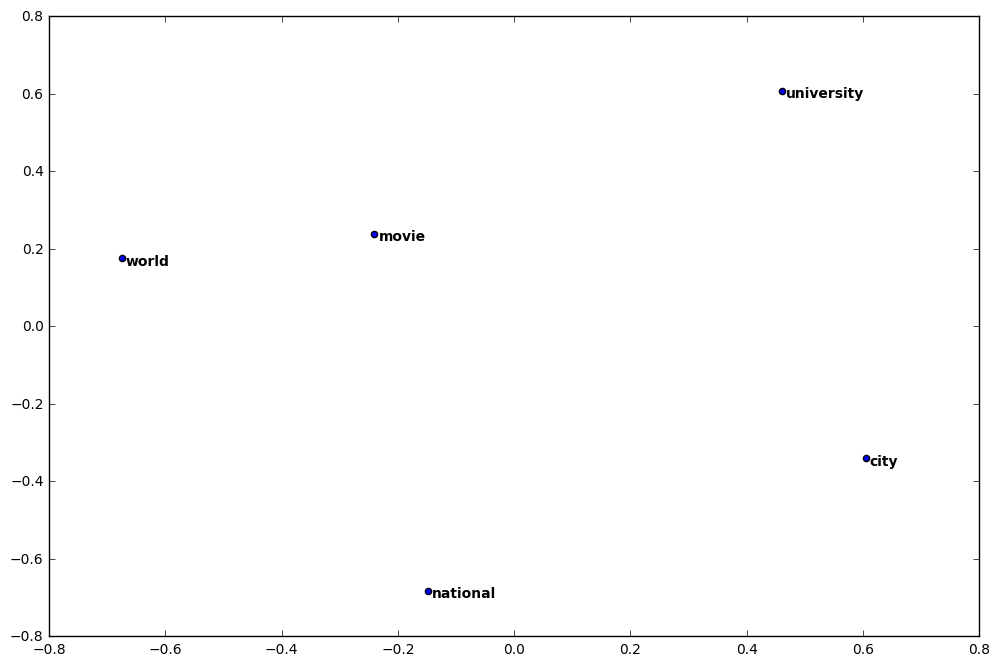

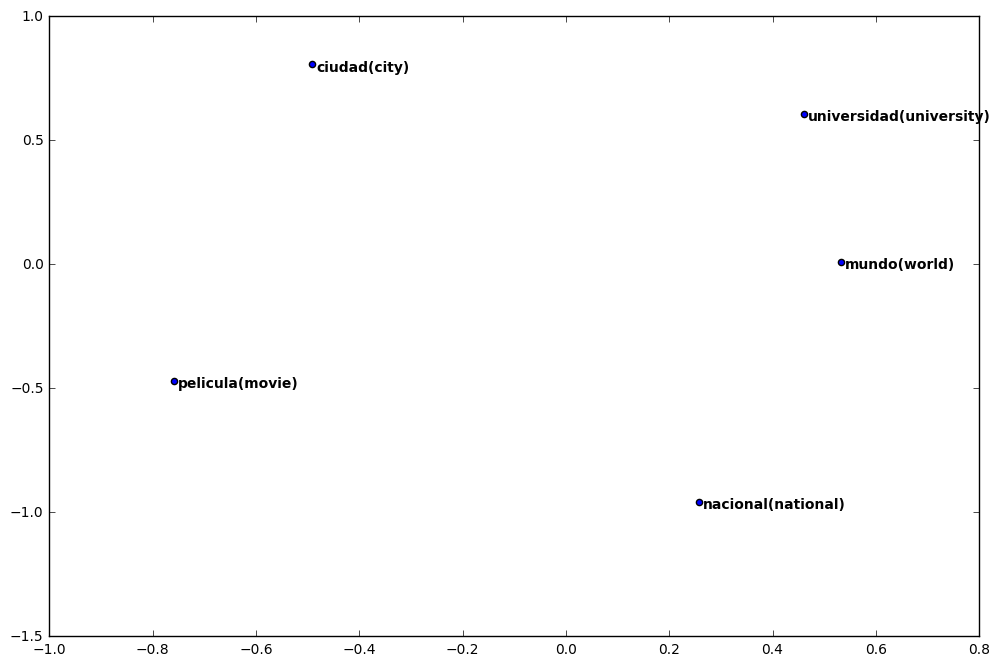

In [79]:
words_en = ['movie','city','world','national','university']
words_es = ['pelicula','ciudad','mundo','nacional','universidad',]
inv_voc_en = create_inverse_voc(voc_en)
inv_voc_es = create_inverse_voc(voc_es)
words_en_idx = [(inv_voc_en[w], w) for w in words_en]
words_es_idx = [(inv_voc_es[w], "%s(%s)" % (w,w_en)) for w,w_en in zip(words_es,words_en)]

def _normalize(word_vec):
    norm=np.linalg.norm(word_vec)
    if norm == 0: 
        return word_vec
    return word_vec/norm

def normalize_vectors(X):
    new = []
    for xi in range(X.shape[0]):
        new.append(_normalize(X[xi,:]))
    return np.array(new)

embed_en = normalize_vectors(rnn_en.predictor.embed.W.data)
embed_es =  normalize_vectors(rnn_es.predictor.embed.W.data)

vis_en = visWord2Vec(embed_en, words_en_idx)
vis_en.do_pca()

vis_es = visWord2Vec(embed_es, words_es_idx)
vis_es.do_pca()

x,y = vis_en.x,vis_es.x
vecs = []
for i in xrange(x.shape[0]):
    vec = np.divide(x[i,:], y[i,:])
    vecs.append(vec)
av = np.diag(vecs[4])
print(np.diag(av))
    
vis_en.plot()
vis_es.plot(av)

In [80]:
np.divide(np.array([ -7.31888199,-20.49064064]),np.array([-13.13213444, 9.28425598]))

array([ 0.55732615, -2.20703099])